 ## Random Forest classification (Jonny)

Here we are going to implement a Random Forest classification algorithm. A Random Forest is composed of different decision tree predictors. For each tree, at each iteration, the data are split into two branches according to a threshold value for one of the features. At each split, the best feature and the best threshold value are chosen by minimizing the entropy function 
𝐻 given by:
$$
\displaystyle H = - \sum_{i=+1,-1} f_i \log_2(f_i)
$$
where $f_i$ is the fraction of points of class $i=+1,-1$ in the training set. The splitting continues until either a maximum depth for the tree is reached, in which case the most frequent class of the branch is assigned to all points, or the points of the branch all belong to the same class (in this case the branch is called a leaf). Different trees are built by randomly drawing data with replacement from the test set, applying the algorithm to each tree. The final label for a point is chosen based on a majority vote of the trees results. 

The hyper-parameters of the model are the **number of trees** and the **maximum depth** of the trees. We are going to implement a K-fold cross validation to choose as best hyper-parameters the ones that maximize the area under the ROC curve of the classifier. To build the ROC curve we need to estimate the probability for the points to belong to a certain class. This can be done because each tree, at the last decision step, assigns a class label based on the majority class of the training samples that reached that final leaf node, but also keeps track of the proportion of the classes in that leaf node. For example, suppose a test point ends up in a leaf node where, out of 100 training samples that ended up there, 80 belonged to class 1 and 20 belonged to class -1. The probability of the point belonging to class 1 would be 0.8, while the probability of it belonging to class -1 would be 0.2.\

We will use the class `RandomForestClassifier` from `scikit-learn` to implement and train the Forest and to predict the labels with their probabilities.   


\
**DA METTERE QUANDO SI INTRODUCE IL CONCETTO DI ROC CURVE?**
The ROC curve plots the True Positive Rate (TPR), i.e: the fraction of actual gamma samples correctly identified as gamma, versus the False Positive Rate, i.e: the fraction of actual hadrons incorrectly classified as gamma by the model. To do so, it's necessary to estimate a probability for the predicted class, not just to assign the predicted label. Imposing different threshold values on the probability for the acceptance of an event as either gamma or hadron, we can obtain the ROC curve.   \
\
**UTILIZZIAMO COME CRITERIO L'INTERA AREA SOTTO LA CURVA O SOLO FINO AD UNA CERTA SOGLIA DI FALSE POSITIVES??**


In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc


# create the validation set to perform K-fold cross validation
train_set, valid_set = split_train_test_set(train_set, 5 )
X_train, Y_train = split_X_Y(train_set)
X_valid, Y_valid = split_X_Y(valid_set)


num_trees= np.arange(40,300,10)
max_depth= np.arange(10,40,2)
accuracies=[]
roc_areas=[]
best_area=0
best_acc=0
best_model= [] # stores best number of trees and best max depth 

for tree in num_trees:
    for depth in max_depth: 
        forest = RandomForestClassifier(n_estimators=tree,  # number of trees
                                       max_depth= depth, 
                                       max_features=X_train.shape[1],   # number of features for each split (random subset)
                                       bootstrap=True,    # bagging (sampling with replacement)
                                       max_samples=1.0,   # percentage of samples to use for each tree (100% of data)
                                       random_state=10,
                                       n_jobs=-1)
        # train each model, predict labels and probability of each label
        forest.fit(X_train, Y_train)
        Y_pred = forest.predict(X_valid)
        y_pred_prob = forest.predict_proba(X_valid)[:, 1] # probability for the validation points to belong to class +1 or -1
        # accuracy on validation set
        accuracy = accuracy_score(Y_valid, Y_pred)
        accuracies.append(accuracy)
        print('Number of trees:',tree,', Maximum depth',depth,':') 
        print('Accuracy:',accuracy)
        # false positive rates and the true positive rates for different threshold values 
        fpr, tpr, thresholds = roc_curve(Y_valid, y_pred_prob)
        # area under the ROC curve on validation set 
        roc_auc = auc(fpr, tpr)
        print('Area under ROC curve:',roc_auc,'\n')
        roc_areas.append(roc_auc)
        if(roc_auc>best_area):
            best_area= roc_auc
            best_acc= accuracy
            best_model=[tree,depth]
        
print('Best number of trees:', best_model[0],'\n')
print('Best maximum depth:', best_model[1],'\n')
print('Area under ROC curve of best model:',best_area)

Number of trees: 40 , Maximum depth 10 :
Accuracy: 0.8106546854942234
Area under ROC curve: 0.86109271163619 

Number of trees: 40 , Maximum depth 12 :
Accuracy: 0.8164313222079589
Area under ROC curve: 0.8675780740998131 

Number of trees: 40 , Maximum depth 14 :
Accuracy: 0.8164313222079589
Area under ROC curve: 0.8701814489857969 

Number of trees: 40 , Maximum depth 16 :
Accuracy: 0.8183568677792041
Area under ROC curve: 0.8722047879656575 

Number of trees: 40 , Maximum depth 18 :
Accuracy: 0.8189987163029525
Area under ROC curve: 0.8724916387959868 

Number of trees: 40 , Maximum depth 20 :
Accuracy: 0.813222079589217
Area under ROC curve: 0.8742996134300483 

Number of trees: 40 , Maximum depth 22 :
Accuracy: 0.8164313222079589
Area under ROC curve: 0.8745765104460757 

Number of trees: 40 , Maximum depth 24 :
Accuracy: 0.8183568677792041
Area under ROC curve: 0.8734300120169686 

Number of trees: 40 , Maximum depth 26 :
Accuracy: 0.8183568677792041
Area under ROC curve: 0.87468

Now we train again the best Random Forest found on the whole training set. We calculate its accuracy and $Q$ factor on the test set, and find the relative ROC curve of the classifier.  

In [58]:
best_forest = RandomForestClassifier(n_estimators=best_model[0], max_depth= best_model[1], max_features=X_train_np.shape[1],bootstrap=True,max_samples=1.0,random_state=10,n_jobs=-1)

best_forest.fit(X_train_np,Y_train_np)
Y_pred = best_forest.predict(X_test_np)
accuracy = accuracy_score(Y_test_np, Y_pred)
print('Accuracy of best Random Forest:',accuracy)

y_pred_prob = best_forest.predict_proba(X_test_np)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test_np, y_pred_prob)
roc_auc_best = auc(fpr, tpr)
print('Area under ROC curve of the best Random Forest:',best_area)

Accuracy of best Random Forest: 0.8353931107020773
Area under ROC curve of the best Random Forest: 0.8804764076503208


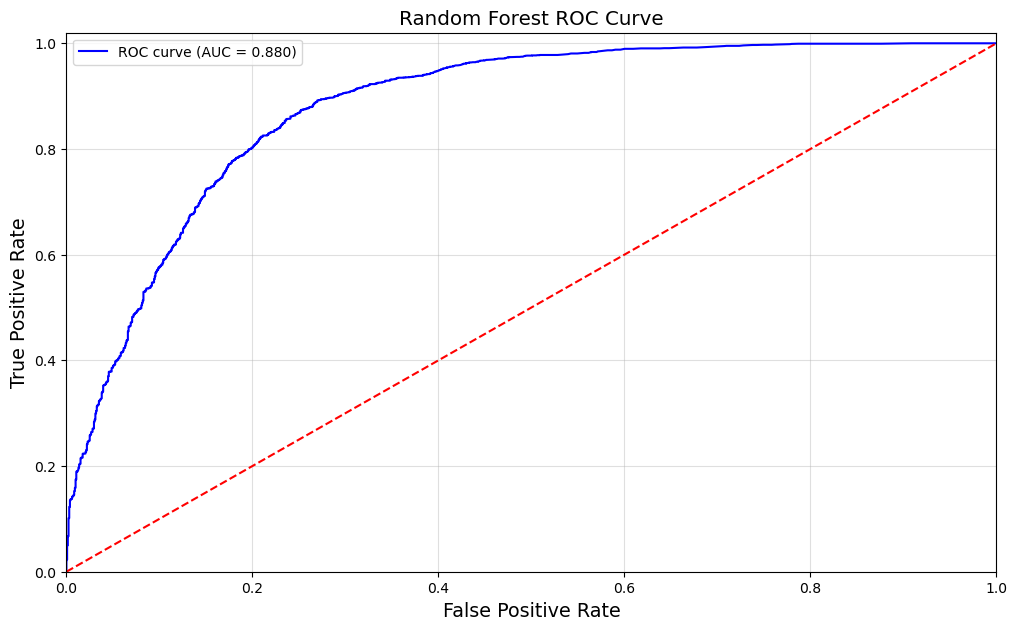

In [119]:
plt.figure(figsize=(12, 7))
plt.plot(fpr, tpr, color='blue', lw=1.5, label=f'ROC curve (AUC = {roc_auc_best:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate',fontsize=13.8)
plt.ylabel('True Positive Rate',fontsize=13.8)
plt.title('Random Forest ROC Curve',fontsize=14.3)
plt.grid(alpha=0.4)
plt.legend(loc='best')
plt.show()

**Q factor??**

**O FORSE MEGLIO METTERE UN NUMERO ALTO DI TREES E CIRCA 26 DEPTH???** \
We plot the behaviour of the area under the ROC curve as a function of the hyper-parameters to spot any significant or useful trend. 

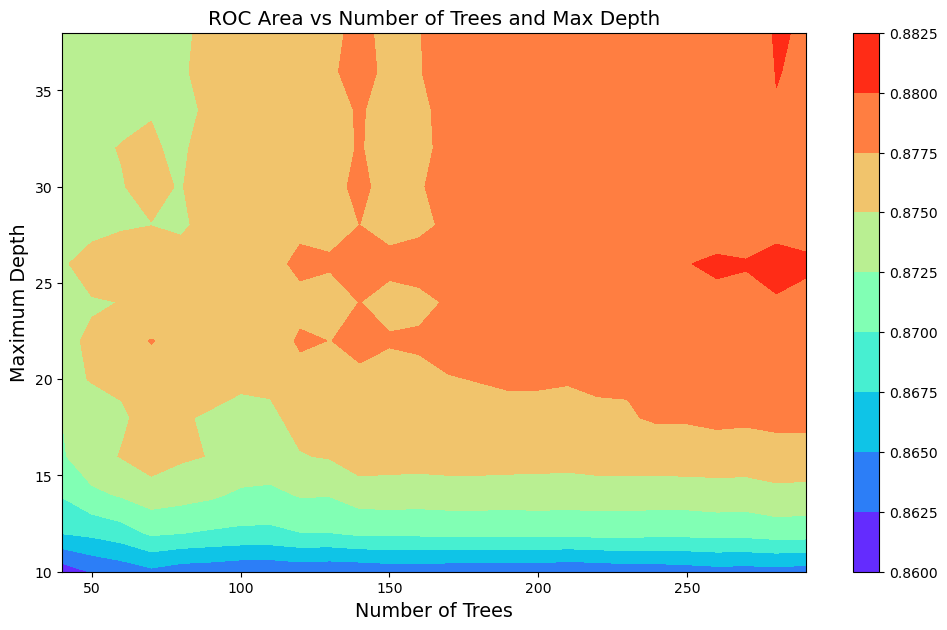

In [127]:
max_depth_grid, num_trees_grid = np.meshgrid(max_depth, num_trees)
roc_areas_grid = np.array(roc_areas).reshape(len(num_trees), len(max_depth)) # reshaping roc_areas to match the grid dimension
plt.figure(figsize=(12, 7))
cp = plt.contourf(num_trees_grid, max_depth_grid, roc_areas_grid, cmap='rainbow')
plt.colorbar(cp)
plt.xlabel('Number of Trees',fontsize=13.8)
plt.ylabel('Maximum Depth',fontsize=13.8)
plt.title('ROC Area vs Number of Trees and Max Depth',fontsize=14.3)
plt.show()
